In [1]:
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, calinski_harabasz_score, silhouette_score
import optuna
from joblib import Parallel, delayed
from utils.Loader import NEUDataset
from utils.Perspectiver import Perspectiver
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import multiprocessing
import torch
from mpl_toolkits.mplot3d import Axes3D
from skimage.restoration import denoise_wavelet
import random
import math

/home/liingfeng/Desktop/pytorch/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class GaussianFilter(torch.nn.Module):
    def __init__(self, kernel_size: int, sigma: float):
        super(GaussianFilter, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.kernel = self._create_gaussian_kernel(kernel_size, sigma)
    
    def _create_gaussian_kernel(self, kernel_size: int, sigma: float):
        """Creates a 2D Gaussian kernel."""
        x = torch.arange(kernel_size) - kernel_size // 2
        y = torch.arange(kernel_size) - kernel_size // 2
        xx, yy = torch.meshgrid(x, y, indexing='ij')
        kernel = torch.exp(-(xx**2 + yy**2) / (2 * sigma**2))
        kernel = kernel / kernel.sum()
        return kernel
    
    def forward(self, x):
        """Applies the Gaussian filter to an input tensor."""
        if x.ndim == 2:  # Add batch and channel dimensions if missing
            x = x.unsqueeze(0).unsqueeze(0)  # Shape [1, 1, H, W]
        
        kernel = self.kernel.to(x.device).unsqueeze(0).unsqueeze(0)  # Shape [1, 1, K, K]
        x = F.conv2d(x, kernel, padding=self.kernel_size // 2)
        return x.squeeze(0).squeeze(0)

In [3]:
dataset = NEUDataset(set="train", transform=None, seed=1, scale=0.5)

# Probar con un DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Intentar iterar sobre el dataloader
for images, labels in dataloader:
    print("Iteración exitosa.")
    print("Imagen shape:", images.shape)
    print("Etiqueta shape:", labels.shape)
    break 

Iteración exitosa.
Imagen shape: torch.Size([4, 1, 100, 100])
Etiqueta shape: torch.Size([4, 6])


In [4]:
image, label = dataset.__getitem__(index=random.randint(2, len(dataset)))
original_image = Perspectiver.grayscale_to_rgb(Perspectiver.normalize_to_uint8(image.detach().cpu().numpy()[0]))

In [5]:
def optimize_image(image, n_tries: int = 100):
    """
    Optimizes the mean shift parameters to maximize the metric: (Silhouette Score / Number of Clusters).

    Args:
        image (np.array): The input image with shape (200, 200, 3).
        n_tries (int): The number of optimization trials to run.

    Returns:
        dict: The best parameters and the best score.
    """

    # Define the objective function for Optuna
    def objective(trial):
        # Suggest parameters for spatial radius and color radius
        sp = trial.suggest_float("sp", 5.0, 60.0)  # Spatial window radius
        sr = trial.suggest_float("sr", sp, sp*2)  # Color window radius

        # Apply mean shift filtering
        after = Perspectiver.meanShift(image, sp, sr)

        # Evaluate clustering
        scores = Perspectiver.evaluate_clustering(image, after)
        score = scores["Davies-Bouldin Index"]
        n_clusters = len(np.unique(after))

        # Avoid division by zero (in case of degenerate clustering)
        if n_clusters == 0:
            return float("-inf")

        # Metric to maximize: Silhouette Score per cluster
        metric_to_maximize = math.log2(score)*n_clusters
        return metric_to_maximize

    # Determine the number of CPU threads
    n_jobs = multiprocessing.cpu_count()-2
    print(f"Using {n_jobs} CPU threads for parallel optimization.")

    # Run the optimization with parallel trials
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_tries, n_jobs=n_jobs)

    # Return the best parameters and the best score
    return {
        "best_params": study.best_params,
        "best_score": study.best_value
    }


In [6]:
def plot_barchartImage(image):
    x = np.arange(image.shape[0])
    y = np.arange(image.shape[1])
    x, y = np.meshgrid(x, y)

    # Flatten arrays for plotting
    x = x.flatten()
    y = y.flatten()
    z = np.zeros_like(x)
    dx = dy = np.ones_like(x)
    dz = image.flatten()

    # Plot the 3D bar chart
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.bar3d(x, y, z, dx, dy, dz, shade=True)

    # Add labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Value')
    ax.set_title('3D Bar Chart of (200, 200) Array')

    plt.show()

In [7]:
BEST = optimize_image(original_image, n_tries=200)["best_params"]


[I 2025-01-28 17:53:57,276] A new study created in memory with name: no-name-ec697985-9c21-41c3-aa6b-3da90c23a3c8


Using 14 CPU threads for parallel optimization.


[I 2025-01-28 17:54:02,563] Trial 11 finished with value: 82.53798119721363 and parameters: {'sp': 55.84584065381181, 'sr': 80.0965811671507}. Best is trial 11 with value: 82.53798119721363.
[I 2025-01-28 17:54:02,650] Trial 12 finished with value: 169.2540874313878 and parameters: {'sp': 47.924923102405565, 'sr': 87.92101333162414}. Best is trial 12 with value: 169.2540874313878.
[I 2025-01-28 17:54:02,667] Trial 2 finished with value: 302.8850123761333 and parameters: {'sp': 44.122796824849765, 'sr': 74.87970452470664}. Best is trial 2 with value: 302.8850123761333.
[I 2025-01-28 17:54:03,459] Trial 7 finished with value: 384.97007393336065 and parameters: {'sp': 37.91737884102212, 'sr': 59.61128340626242}. Best is trial 7 with value: 384.97007393336065.
[I 2025-01-28 17:54:03,543] Trial 13 finished with value: 665.539592965119 and parameters: {'sp': 27.183376808048564, 'sr': 51.36464520543159}. Best is trial 13 with value: 665.539592965119.
[I 2025-01-28 17:54:03,610] Trial 8 finish

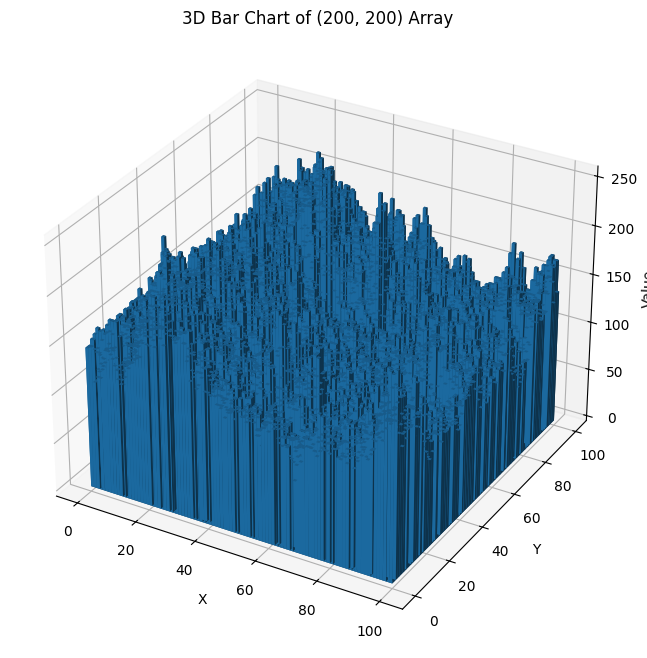

In [8]:
plot_barchartImage(Perspectiver.rgb_to_grayscale(original_image))

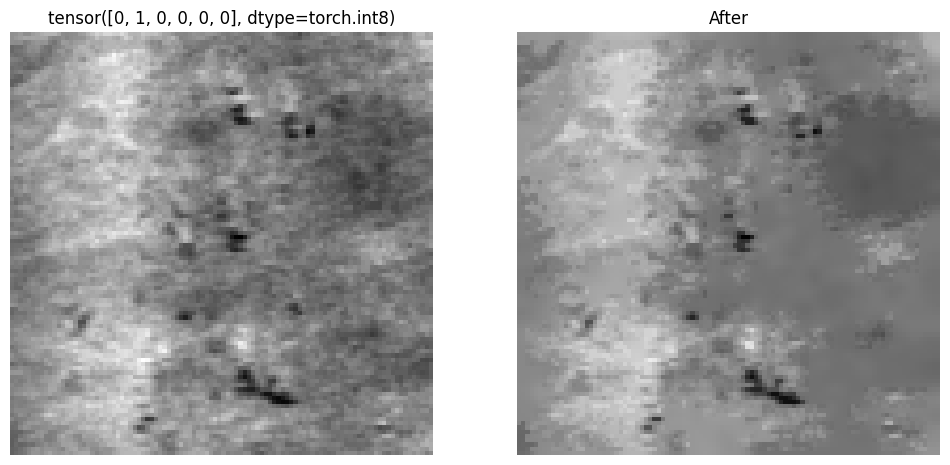

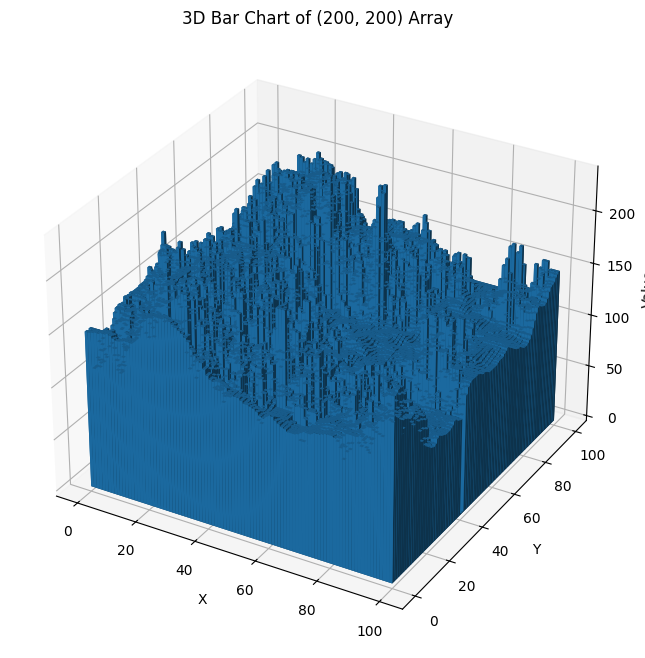

{'Silhouette Score': -0.35956769486399937,
 'Davies-Bouldin Index': 71666.06683186858,
 'Calinski-Harabasz Index': 1047.1820042875172,
 'Silhouette Score/n': -0.0020664810049655135,
 'Davies-Bouldin Index/n': 411.87394730958954,
 'Calinski-Harabasz Index/n': 6.018287380962742}

In [9]:
clustered_image = Perspectiver.meanShift(original_image, BEST["sp"], BEST["sr"])
Perspectiver.plotComparison(original_image, clustered_image, titleBefore=label)
plot_barchartImage(Perspectiver.rgb_to_grayscale(clustered_image))
Perspectiver.evaluate_clustering(original_image, clustered_image)